In [ ]:
import onnxruntime as rt
import pandas as pd
import numpy as np
from Tester import TesterGroup1
%load_ext autoreload
%autoreload 2
np.random.seed(42)


In [2]:
def load_models(model1_path="model_1.onnx", model2_path="model_2.onnx"):
    """
    Loads the ONNX models and prints their input requirements.
    """
    try:
        # Initialize Inference Sessions
        # Provider 'CPUExecutionProvider' is standard for general testing
        sess_1 = rt.InferenceSession(model1_path, providers=['CPUExecutionProvider'])
        sess_2 = rt.InferenceSession(model2_path, providers=['CPUExecutionProvider'])

        print("--- Model Loading Successful ---")

        for i, sess in enumerate([sess_1, sess_2], 1):
            input_meta = sess.get_inputs()[0]
            output_meta = sess.get_outputs()[0]

            print(f"\nModel {i} Metadata:")
            print(f"  Input Name:  {input_meta.name}")
            print(f"  Input Shape: {input_meta.shape}")
            print(f"  Output Name: {output_meta.name}")

        return sess_1, sess_2

    except Exception as e:
        print(f"Error loading models: {e}")
        return None, None

# Usage example:
# session_bad, session_good = load_rotterdam_models()

# Example of how to run a single prediction:
# dummy_input = np.zeros((1, 315), dtype=np.float32)
# result = session_bad.run(None, {'float_input': dummy_input})

In [3]:
def load_data():
    global X_train, y_train, X_test, y_test, X_train_all, X_test_all
    X_train_all = pd.read_csv("../data/train.csv")
    X_test_all = pd.read_csv("../data/test.csv")
    y_train = X_train_all['checked']
    y_test = X_test_all['checked']
    X_train = X_train_all.drop(columns=['checked'], errors='ignore', inplace=False)
    X_test = X_test_all.drop(columns=['checked'], errors='ignore', inplace=False)

In [4]:
import pandas as pd
import numpy as np
import onnxruntime as rt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_classical_metrics(sess, model_name="Model"):
    """
    Evaluates an ONNX model session using standard ML performance metrics
    against the global X_test and y_test datasets.
    """
    # 1. Access the global test data loaded by load_data()
    global X_test, y_test, X_train_all, y_train_all, X_test_all, y_test_all, X_train, y_train

    # 2. Get the input name from the ONNX session
    input_name = sess.get_inputs()[0].name

    # 3. Prepare features: ONNX requires float32 and a numpy array
    X_features = X_test.values.astype(np.float32)

    # 4. Run Inference
    # sess.run returns a list of outputs; we take the first one (predictions)
    raw_results = sess.run(None, {input_name: X_features})
    y_pred = raw_results[0].flatten()

    # 5. Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Note: AUC-ROC usually requires probabilities.
    # If your model only outputs hard classes (0/1), this will be a rough estimate.
    auc = roc_auc_score(y_test, y_pred)

    print(f"\n--- Classical ML Evaluation: {model_name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return {"accuracy": acc, "f1": f1, "auc": auc}

# --- Execution ---
# Assumes you have already run:
# load_data()
# loaded_model1, loaded_model2 = load_models()


In [5]:
load_data()
loaded_model1, loaded_model2 = load_models()


--- Model Loading Successful ---

Model 1 Metadata:
  Input Name:  float_input
  Input Shape: [None, 317]
  Output Name: output_label

Model 2 Metadata:
  Input Name:  float_input
  Input Shape: [None, 317]
  Output Name: output_label


In [6]:
evaluate_classical_metrics(loaded_model1)


--- Classical ML Evaluation: Model ---
Accuracy:  0.8594
F1-Score:  0.3157
AUC-ROC:   0.5945

Confusion Matrix:
[[21502   597]
 [ 3058   843]]


{'accuracy': 0.859423076923077,
 'f1': np.float64(0.31567122261748737),
 'auc': np.float64(0.5945418196243724)}

In [7]:
evaluate_classical_metrics(loaded_model2)


--- Classical ML Evaluation: Model ---
Accuracy:  0.8536
F1-Score:  0.1036
AUC-ROC:   0.5254

Confusion Matrix:
[[21974   125]
 [ 3681   220]]


{'accuracy': 0.8536153846153847,
 'f1': np.float64(0.10362694300518134),
 'auc': np.float64(0.5253697157041872)}

In [8]:
import onnxruntime


class ONNXModelAdapter:
    def __init__(self, model_path, model_features):
        self.session = onnxruntime.InferenceSession(
            model_path,
            providers=["CPUExecutionProvider"]
        )
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name
        self.model_features = model_features

    def predict(self, X):
        # print((self.session.get_inputs()[0].))
        # print(set(X.columns)-set(self.session.get_inputs()[0]))
        preds = self.session.run(
            [self.output_name],
            {self.input_name: X.astype(np.float32).values}
        )[0]
        return preds.astype(int)

In [9]:
%load_ext autoreload
%autoreload 2
protected_features = [
    'persoon_geslacht_vrouw',
    'persoon_leeftijd_bij_onderzoek',
    'persoonlijke_eigenschappen_taaleis_voldaan'
]
neighborhood_proxies = [c for c in X_train.columns if 'neighborhood' in c or 'district' in c]
toxic_features = protected_features + neighborhood_proxies

safe_core = [
    'ontheffing_hist_ind',
    'pla_hist_pla_categorie_doelstelling_16',
    'persoonlijke_eigenschappen_taaleis_schrijfv_ok',
    'contacten_soort_telefoontje__uitgaand_',
    'contacten_onderwerp__arbeids_motivatie',
    'contacten_soort_document__uitgaand_',
    'contacten_soort_telefoontje__inkomend_',
    'contacten_onderwerp_terugbelverzoek',
    'pla_actueel_pla_categorie_doelstelling_16',
    'contacten_onderwerp_ziek__of_afmelding'
]
all_features = safe_core + toxic_features
tester1 = TesterGroup1(ONNXModelAdapter("model_1.onnx", all_features), X_train)
tester2 = TesterGroup1(ONNXModelAdapter("model_2.onnx", all_features), X_train)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adres_aantal_verzendadres', 'adres_aantal_woonadres_handmatig', 'adres_dagen_op_adres', 'adres_recentst_onderdeel_rdam', 'adres_recentste_buurt_groot_ijsselmonde', 'adres_recentste_buurt_nieuwe_westen', 'adres_recentste_buurt_other', 'adres_recentste_buurt_oude_noorden', 'adres_recentste_buurt_vreewijk', 'adres_recentste_plaats_other', 'adres_recentste_plaats_rotterdam', 'adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other', 'adres_recentste_wijk_prins_alexa', 'adres_recentste_wijk_stadscentru', 'adres_unieke_wijk_ratio', 'afspraak_aanmelding_afgesloten', 'afspraak_aantal_woorden', 'afspraak_afgelopen_jaar_afsprakenplan', 'afspraak_afgelopen_jaar_monitoring_i

PermutationExplainer explainer: 101it [00:37,  2.24it/s]                         


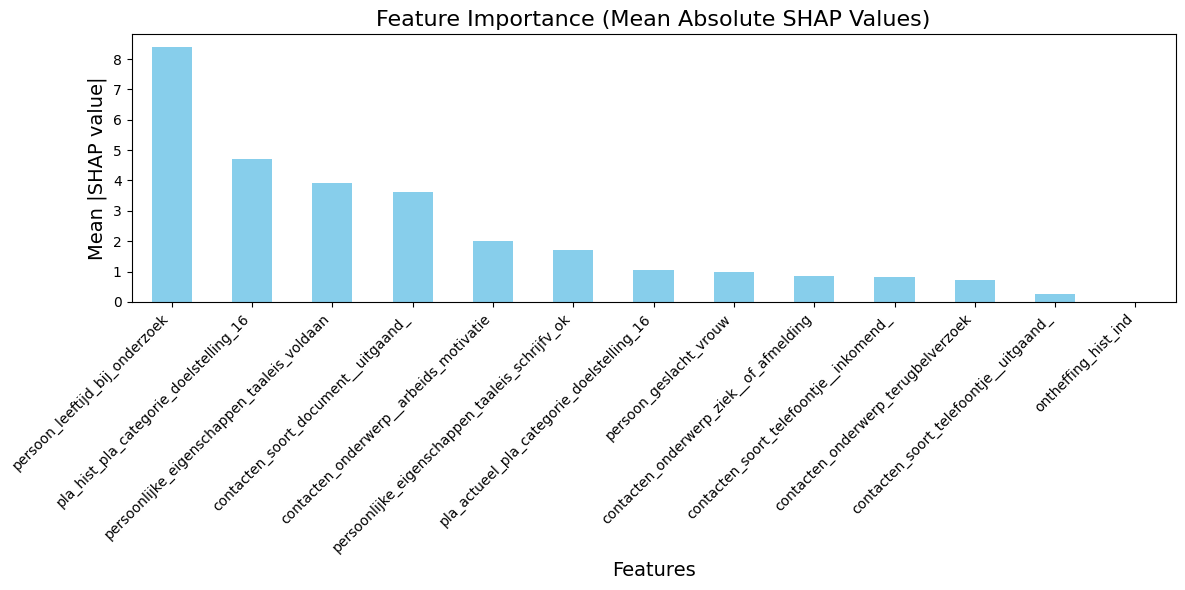

In [10]:
shap_values1 = tester1.test_shapley_values()

PermutationExplainer explainer: 101it [00:32,  2.10it/s]                         


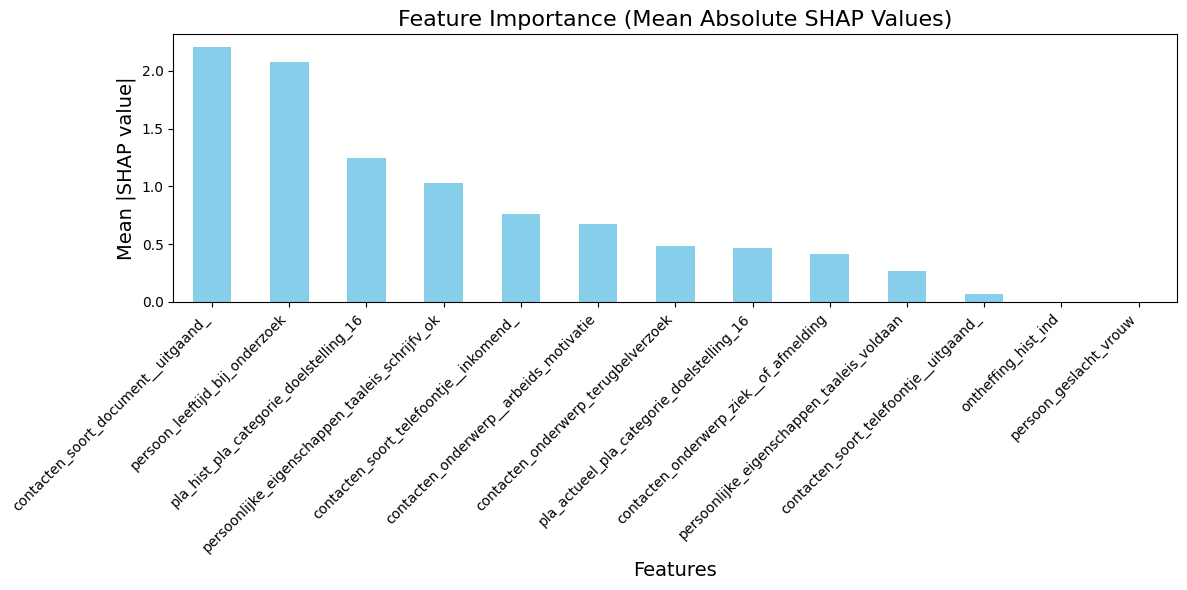

In [11]:
shap_values2 = tester2.test_shapley_values()

In [12]:
tester1.run_partition_tests()

PASS: Gender Partitioning (Diff: 0.0033)
PASS: Neighborhood Partitioning (Ratio: 1.02)

------------------------------------------------------------
PARTITIONING TESTS SUMMARY:
  [PASS] Gender
  [FAIL] Language: Group Bias: Language barrier group is 5.08x riskier.
  [FAIL] Age: Group Bias: Seniors receive 1.59x risk score than youth.
  [PASS] Neighborhood
------------------------------------------------------------


[('Gender', 'PASS', None),
 ('Language', 'FAIL', 'Group Bias: Language barrier group is 5.08x riskier.'),
 ('Age', 'FAIL', 'Group Bias: Seniors receive 1.59x risk score than youth.'),
 ('Neighborhood', 'PASS', None)]

In [13]:
tester2.run_partition_tests()

PASS: Gender Partitioning (Diff: 0.0046)
PASS: Neighborhood Partitioning (Ratio: 0.88)

------------------------------------------------------------
PARTITIONING TESTS SUMMARY:
  [PASS] Gender
  [FAIL] Language: Group Bias: Language barrier group is 2.18x riskier.
  [FAIL] Age: Group Bias: Seniors receive 1.52x risk score than youth.
  [PASS] Neighborhood
------------------------------------------------------------


[('Gender', 'PASS', None),
 ('Language', 'FAIL', 'Group Bias: Language barrier group is 2.18x riskier.'),
 ('Age', 'FAIL', 'Group Bias: Seniors receive 1.52x risk score than youth.'),
 ('Neighborhood', 'PASS', None)]

In [14]:
tester1.run_metamorphic_tests()


PASS: Gender Metamorphic
PASS: Neighborhood Metamorphic (Max diff: 0.0000)

------------------------------------------------------------
METAMORPHIC TESTS SUMMARY:
  [FAIL] Age: Consistency Error: Small age change caused 1.0000 risk change.
  [PASS] Gender
  [FAIL] Language: Consistency Error: Improving language skills changed individual risk. Max diff: 1.000000
  [PASS] Neighborhood
------------------------------------------------------------


[('Age',
  'FAIL',
  'Consistency Error: Small age change caused 1.0000 risk change.'),
 ('Gender', 'PASS', None),
 ('Language',
  'FAIL',
  'Consistency Error: Improving language skills changed individual risk. Max diff: 1.000000'),
 ('Neighborhood', 'PASS', None)]

In [15]:

tester2.run_metamorphic_tests()

PASS: Age Metamorphic (Max change: 0.0000)
PASS: Gender Metamorphic
PASS: Language Metamorphic
PASS: Neighborhood Metamorphic (Max diff: 0.0000)

------------------------------------------------------------
METAMORPHIC TESTS SUMMARY:
  [PASS] Age
  [PASS] Gender
  [PASS] Language
  [PASS] Neighborhood
------------------------------------------------------------


[('Age', 'PASS', None),
 ('Gender', 'PASS', None),
 ('Language', 'PASS', None),
 ('Neighborhood', 'PASS', None)]